In [ ]:
from pointnet2_benny import pointnet2_cls_ssg
from sklearn.metrics import *

from final_models.combined_models import *

In [24]:
data_path = "/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/scratch-disk/full-datasets/hcampus-1.5T-cohort-holdout"

In [25]:
subject_list = find_subjects_parallel(data_path)
    

Csv files: ['/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/scratch-disk/full-datasets/hcampus-1.5T-cohort-holdout/idaSearch_3_19_2025.csv']


In [26]:
for subject in subject_list:

    subject.data = {}

    # Group
    mapping = {
        'CN': 0,
        'MCI': 1,
    }

    # Get the value of the mapping, -1 if not found
    subject.data['research_group'] = mapping.get(subject.subject_metadata['Research Group'].iloc[0], -1)

    # Cloud
    subject.data['lhcampus_pointcloud_aligned'] = np.load(os.path.join(subject.path, 'Left-Hippocampus_aligned_cropped_mesh_downsampledcloud.npy'))

    # Volumes
    volume_col = subject.aseg_stats['Volume_mm3']
    volume_col_normalised = volume_col / volume_col.sum() * 1000
    struct_name_col = subject.aseg_stats['StructName']
    
    subject.data['volumes'] = np.array(volume_col_normalised)
    
    subject.data['struct_names'] = np.array(struct_name_col)

    # Scores
    mmse = subject.subject_metadata['MMSE Total Score'].iloc[0]
    gdscale = subject.subject_metadata['GDSCALE Total Score'].iloc[0]
    faq = subject.subject_metadata['FAQ Total Score'].iloc[0]
    npiq = subject.subject_metadata['NPI-Q Total Score'].iloc[0]

    subject.data['scores'] = [mmse, gdscale, faq, npiq]

    subject.data['score_names'] = ['MMSE Total Score', 'GDSCALE Total Score', 'FAQ Total Score', 'NPI-Q Total Score']

Evaluate pointnet

- Best roc for pkl on cuda: 0.702 seed 40
- Best roc for pth on cuda: 0.702 seed 90
- Best roc for pkl on cpu:

In [27]:
best_roc_auc = -np.inf

for seed in range(100):

    true = []
    pred_probs = []
    pred_classes = []

    for subject in subject_list:

        pred_research_group, pred_class, output = get_pointnet_prediction(subject.data['lhcampus_pointcloud_aligned'], 'cpu', seed=seed, mode = 'pkl')

        true.append(subject.data['research_group'])
        
        pred_probs.append(output)

        pred_classes.append(pred_class)

    current_roc_auc = roc_auc_score(true, pred_probs) 

    print(current_roc_auc)

    if current_roc_auc > best_roc_auc:

        best_roc_auc = current_roc_auc

        best_seed = seed

print(best_seed)
print(best_roc_auc)


0.6086956521739131
0.5978260869565217
0.6304347826086956
0.6557971014492754
0.673913043478261
0.6376811594202898
0.6521739130434783
0.6304347826086957
0.6521739130434783
0.6884057971014491
0.6557971014492754
0.6594202898550724
0.6630434782608696
0.6702898550724639
0.6702898550724639
0.6304347826086957
0.6449275362318841
0.6340579710144928
0.6485507246376812
0.6666666666666666
0.6413043478260869
0.6847826086956521
0.6956521739130435
0.6557971014492754
0.6920289855072463
0.6376811594202898
0.6557971014492754
0.6521739130434783
0.6702898550724639
0.6376811594202898
0.6557971014492754
0.6811594202898551
0.6268115942028987
0.644927536231884
0.6557971014492754
0.6413043478260869
0.6521739130434783
0.6666666666666666
0.6485507246376812
0.6594202898550725
0.6557971014492754
0.6630434782608696
0.6340579710144928
0.6920289855072463
0.6594202898550725
0.6557971014492754
0.6340579710144928
0.6231884057971016
0.6811594202898551
0.6811594202898551
0.6594202898550725
0.6485507246376812
0.688405797101

In [28]:
true = []
pred_probs = []
pred_classes = []

for subject in subject_list:

    pred_research_group, pred_class, output = get_pointnet_prediction(subject.data['lhcampus_pointcloud_aligned'], 'cuda', seed=best_seed, mode = 'pth')

    true.append(subject.data['research_group'])
    
    pred_probs.append(output)

    pred_classes.append(pred_class)

0.7028985507246377
0.7755102040816326


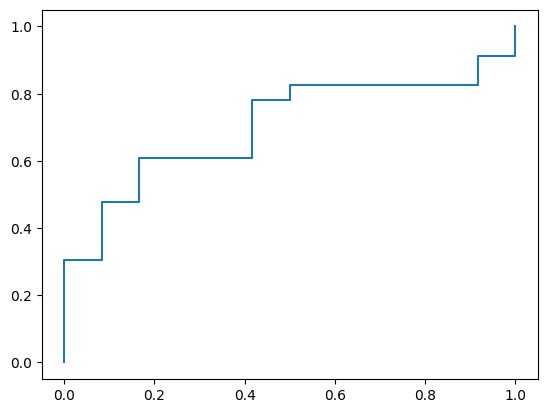

In [29]:
roc_auc = roc_auc_score(true, pred_probs)
print(roc_auc)

f1 = f1_score(true, pred_classes)
print(f1)

fpr, tpr, thresholds = roc_curve(true, pred_probs)

plt.plot(fpr, tpr)

plt.show()

Evaluate volumes gbdt

In [30]:
true = []
pred_probs = []
pred_classes = []

for subject in subject_list:

    pred_research_group, pred_class, output = get_volumes_prediction(subject.data['volumes'])

    true.append(subject.data['research_group'])
    
    pred_probs.append(output)

    pred_classes.append(pred_class)

0.8242753623188406
0.7931034482758621


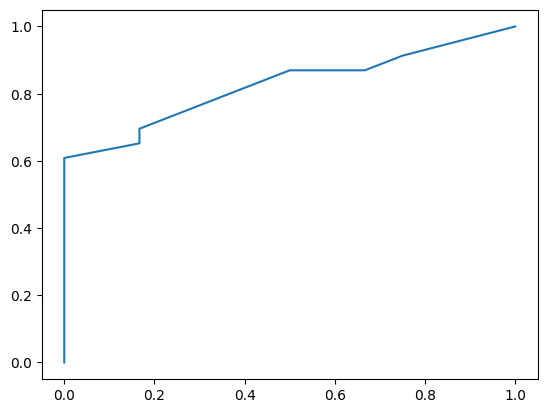

In [31]:
roc_auc = roc_auc_score(true, pred_probs)
print(roc_auc)

f1 = f1_score(true, pred_classes)
print(f1)

fpr, tpr, thresholds = roc_curve(true, pred_probs)

plt.plot(fpr, tpr)

plt.show()

Evaluate scores gbdt

In [32]:
true = []
pred_probs = []
pred_classes = []

for subject in subject_list:

    pred_research_group, pred_class, output = get_scores_prediction(subject.data['scores'])

    true.append(subject.data['research_group'])
    
    pred_probs.append(output)

    pred_classes.append(pred_class)

0.8007246376811594
0.7916666666666666


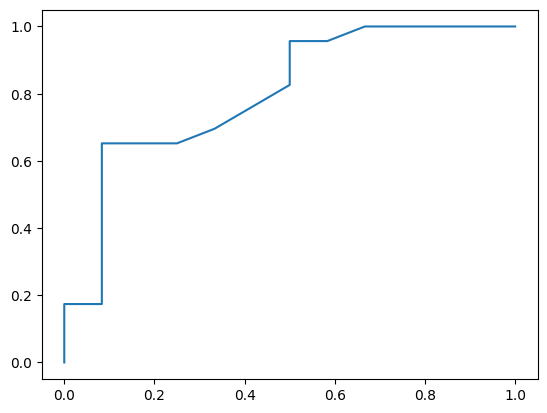

In [33]:
roc_auc = roc_auc_score(true, pred_probs)
print(roc_auc)

f1 = f1_score(true, pred_classes)
print(f1)

fpr, tpr, thresholds = roc_curve(true, pred_probs)

plt.plot(fpr, tpr)

plt.show()

Evaluate ensemble

In [34]:
true = []
pred_probs = []
pred_classes = []

for subject in subject_list:

    pred_research_group, pred_class, output = get_ensemble_prediction_avg(subject.data)

    true.append(subject.data['research_group'])
    
    pred_probs.append(output)

    pred_classes.append(pred_class)

0.7717391304347826
0.7659574468085106


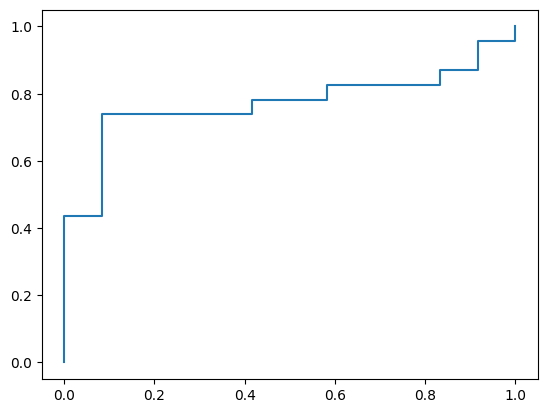

In [35]:
roc_auc = roc_auc_score(true, pred_probs)
print(roc_auc)

f1 = f1_score(true, pred_classes)
print(f1)

fpr, tpr, thresholds = roc_curve(true, pred_probs)

plt.plot(fpr, tpr)

plt.show()

In [36]:
true = []
pred_probs = []
pred_classes = []

models_used = []

for subject in subject_list:

    pred_research_group, pred_class, output, model = get_ensemble_prediction_maxprob(subject.data)

    true.append(subject.data['research_group'])
    
    pred_probs.append(output)

    pred_classes.append(pred_class)

    models_used.append(model)

(array([0, 1, 2]), array([19,  1, 15]))
0.7771739130434783
0.782608695652174


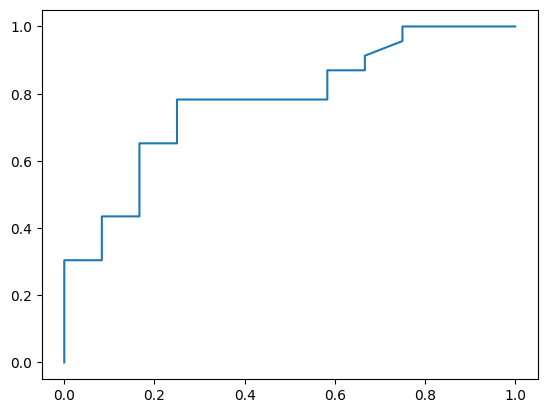

In [37]:
print(np.unique(models_used, return_counts=True))

roc_auc = roc_auc_score(true, pred_probs)
print(roc_auc)

f1 = f1_score(true, pred_classes)
print(f1)

fpr, tpr, thresholds = roc_curve(true, pred_probs)

plt.plot(fpr, tpr)

plt.show()